### Problem Statement
Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.

Malaria must be recognized promptly in order to treat the patient in time and to prevent further spread of infection in the community via local mosquitoes.
Malaria should be considered a potential medical emergency and should be treated accordingly. Delay in diagnosis and treatment is a leading cause of death in malaria patients in the United States.

Diagnosis of malaria can be difficult:

* here malaria is not endemic any more (such as in the United States), health-care providers may not be familiar with the disease. Clinicians seeing a malaria patient may forget to consider malaria among the potential diagnoses and not order the needed diagnostic tests. Laboratorians may lack experience with malaria and fail to detect parasites when examining blood smears under the microscope.
* In some malaria-endemic areas, malaria transmission is so intense that a large proportion of the population is infected but not made ill by the parasites. Such carriers have developed just enough immunity to protect them from malarial illness but not from malarial infection. In that situation, finding malaria parasites in an ill person does not necessarily mean that the illness is caused by the parasites.

(source: [cdc.gov](cdc.gov/malaria/diagnosis_treatment/diagnosis.html))

With given cell images dataset we try to classife whether patient is ill or not. 
Dataset may be devided into two separate sets: parasitized cells and uninfected cells. Its a simple classification problem with 2 labels. 
Images with parasite will be marked as 1 and uninfected as 0. We use CNN to perform a classification. 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from keras import backend, optimizers
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, GlobalAveragePooling2D, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold

Using TensorFlow backend.


In [2]:
parasitized_dir = 'data/cell_images/Parasitized'
uninfected_dir = 'data/cell_images/Uninfected'
parasitized_cells = os.listdir(parasitized_dir)
uninfected_cells = os.listdir(uninfected_dir)

In [3]:
def plot_examples(photo_names: list, photo_dir: str) -> None:
    plt.figure(figsize = (15,15))
    for num, img_name in enumerate(photo_names):
        plt.subplot(1, len(photo_names), num + 1)
        img_path = os.path.join(photo_dir, img_name)
        pil_im = Image.open(img_path, 'r')
        plt.imshow(pil_im)
        plt.tight_layout()
    plt.show()

##### Parasitized cells example
Visualization of of infected and uninfected cells images.

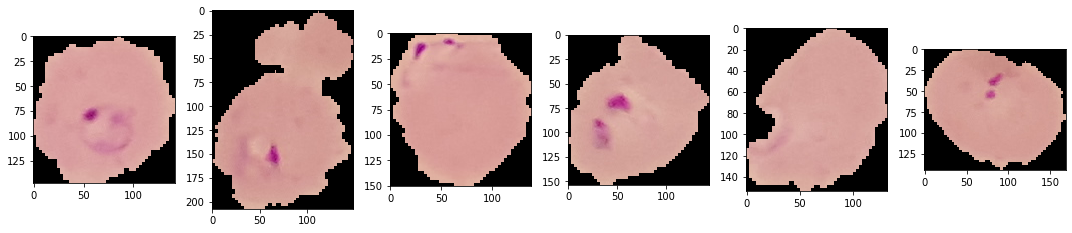

In [4]:
example_parasitized_cells = parasitized_cells[:6]

plot_examples(example_parasitized_cells, parasitized_dir)

##### Uninfected cells example

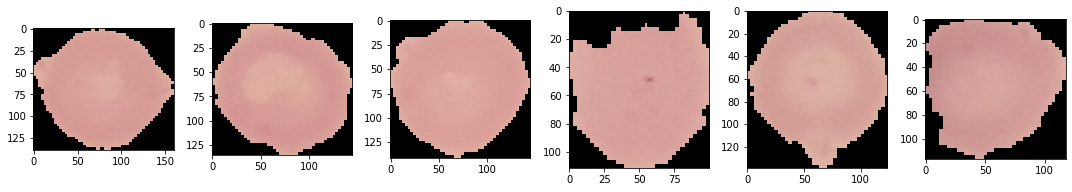

In [5]:
example_uninfected_cells = uninfected_cells[:6]

plot_examples(example_uninfected_cells, uninfected_dir)

We can see quite significant differences at the pictures. Parasitized cell have visible swings on the surface. These differences are good work for CNNs.

##### Data preprocessing
Data preprocessing and labeling is pretty straightforward. Everything what I have done is resizing to 50x50 images.

In [6]:
def preprocess_images(images: list, base_path: str, img_label: int, resize: tuple = (50, 50)) -> tuple:
    X, y = [], []
    for image in images:
        try:
            img_arr = plt.imread(os.path.join(base_path, image))
            resized_img = cv2.resize(img_arr, resize)
            y.append(img_label)
            X.append(resized_img)
        except OSError as exc:
            print(exc)
    return X, y

In [7]:
X_p, y_p = preprocess_images(parasitized_cells, parasitized_dir, 1)
X_u, y_u = preprocess_images(uninfected_cells, uninfected_dir, 0)

cannot identify image file 'data/cell_images/Parasitized\\Thumbs.db'
cannot identify image file 'data/cell_images/Uninfected\\Thumbs.db'


In [8]:
X = np.array([*X_p, *X_u])
y = np.array([*y_p, *y_u])

Splitting data in proporion 7:3

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [10]:
y_train = np_utils.to_categorical(y_train, num_classes = 2)
y_test = np_utils.to_categorical(y_test, num_classes = 2)

CNN built for image recognition is a simple CNN with two CONV => RELU => POOL => CONV => RELU layers and single fully connected layer. I've also used BatchNormalization layer after each RELU activation making our network train faster, converage more quickly and making activation function more viable. 

In [11]:
class CNNNet:
    @staticmethod
    def build(width: int, height: int, depth: int, classes: int):
        model = Sequential()
        input_shape = (height, width, depth)
        channel_dimension = -1
        
        if backend.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
            channel_dimension = 1
            
        # first CONV => RELU => POOL => CONV => RELU layer set
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Dropout(0.2))

        # second CONV => RELU => POOL => CONV => RELU layer set
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Conv2D(32, (3, 3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Dropout(0.2))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dimension))
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

##### Data augmentation

CNN needs a lot of data. Thanks tu Data Augmentaion process we can genarete enough data for our model. I've tried simple data augmentation (small zooms, small rotations and pretty small horizontal/vertical shifts)

In [12]:
train_image_generator = ImageDataGenerator(
#         rescale=1/255.,
        fill_mode='nearest',  # fill points outside the boundaries 
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False  # randomly flip images
)  

validation_image_generator = ImageDataGenerator(
#     rescale=1/255.
)

In [13]:
train_data = train_image_generator.flow(X_train, y_train, batch_size=64, shuffle=True)
validation_data = validation_image_generator.flow(X_test, y_test, batch_size=64, shuffle=True)

In [14]:
height, width, depth = 50, 50, 3
classes = 2

model = CNNNet.build(width, height, depth, classes)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 32)       

In [15]:
steps_per_epoch = X_train.shape[0] // 64
adam_optimizer = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [19]:
history = model.fit_generator(
    train_data, 
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_data,
    validation_steps=6
)

Epoch 1/50
301/301 [==============================] - 11s 37ms/step - loss: 0.1454 - accuracy: 0.9489 - val_loss: 0.0367 - val_accuracy: 0.9609
Epoch 2/50
301/301 [==============================] - 11s 38ms/step - loss: 0.1495 - accuracy: 0.9459 - val_loss: 0.0333 - val_accuracy: 0.9583
Epoch 3/50
301/301 [==============================] - 11s 37ms/step - loss: 0.1509 - accuracy: 0.9437 - val_loss: 0.0500 - val_accuracy: 0.9505
Epoch 4/50
301/301 [==============================] - 11s 36ms/step - loss: 0.1450 - accuracy: 0.9487 - val_loss: 0.1277 - val_accuracy: 0.9479
Epoch 5/50
301/301 [==============================] - 11s 37ms/step - loss: 0.1525 - accuracy: 0.9465 - val_loss: 0.1571 - val_accuracy: 0.9557
Epoch 6/50
301/301 [==============================] - 11s 37ms/step - loss: 0.1445 - accuracy: 0.9475 - val_loss: 0.1140 - val_accuracy: 0.9583
Epoch 7/50
301/301 [==============================] - 11s 37ms/step - loss: 0.1513 - accuracy: 0.9476 - val_loss: 0.0728 - val_accuracy:

In [25]:
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

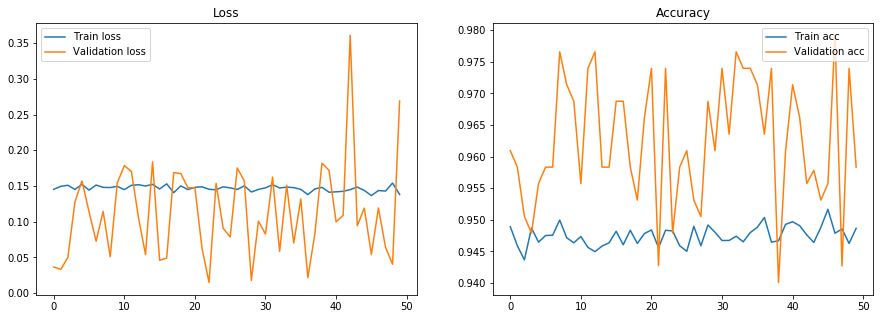

In [26]:
show_history(history)

In [27]:
predict = model.evaluate_generator(validation_data, steps=4)

In [28]:
print(f"Loss on test data set: {predict[0]:.5f}. Accuracy on test dataset: {predict[1] * 100:.2f}%")

Loss on test data set: 0.08317. Accuracy on test dataset: 95.70%


In [29]:
def show_random_predictions(model, X_test):
    predictions = model.predict(X_test)
    print(predictions)
    for i, row in enumerate(predictions):
        is_parasitized = row[0] <= row[1]
        label = "Parasitized" if is_parasitized else "Uninfected"
        plt.title(label)
        plt.imshow(X_test[i])
        plt.show()

[[4.0698182e-04 9.9959308e-01]
 [9.3226737e-01 6.7732587e-02]
 [3.1645693e-02 9.6835428e-01]
 [9.9305880e-01 6.9411620e-03]
 [9.7104204e-01 2.8957920e-02]]


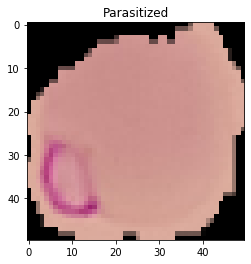

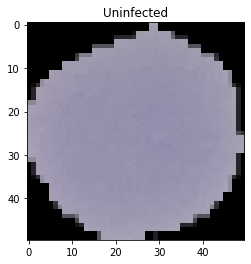

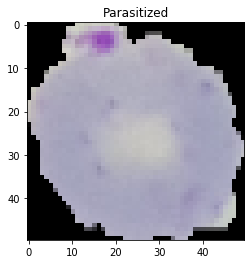

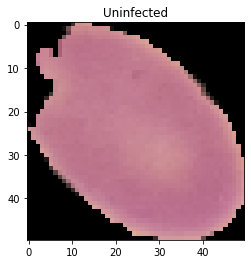

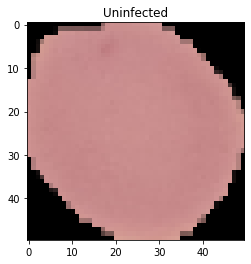

In [35]:
random_data = X_test[np.random.randint(X_test.shape[0], size=5), :]
show_random_predictions(model, random_data)

##### Training model using k-fold approach
Kfold provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default). Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
K-Fold is a popular and easy to understand, it generally results in a less biased model compare to other methods. Because it ensures that every observation from the original dataset has the chance of appearing in training and test set. 

In [36]:
split_num = 5
kf = KFold(n_splits = 5, shuffle = True)

In [37]:
y_categorical = np_utils.to_categorical(y, num_classes = 2)

In [38]:
def kfold_training(model, X: np.ndarray, y: np.ndarray, kfold_splitter: KFold) -> list:
    scores = []
    for _ in range(split_num):
        kfold_indcies = next(kfold_splitter.split(X), None)
        
        X_train = X[kfold_indcies[0]]
        y_train = y_categorical[kfold_indcies[0]]
        X_test = X[kfold_indcies[1]]
        y_test = y_categorical[kfold_indcies[1]]
        
        steps_per_epoch = X_train.shape[0] // 64

        train_data = train_image_generator.flow(X_train, y_train, batch_size=64, shuffle=True)
        validation_data = validation_image_generator.flow(X_test, y_test, batch_size=64, shuffle=True)

        history = model.fit_generator(
            train_data, 
            epochs=50,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_data,
            validation_steps=6,
            verbose=1
        )

        predict = model.evaluate_generator(validation_data, steps=4)
        scores.append(predict)
    
    return scores

In [39]:
scores = kfold_training(model, X, y_categorical, kf)

Epoch 1/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1499 - accuracy: 0.9461 - val_loss: 0.1513 - val_accuracy: 0.9661
Epoch 2/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1516 - accuracy: 0.9454 - val_loss: 0.0324 - val_accuracy: 0.9740
Epoch 3/50
344/344 [==============================] - 13s 36ms/step - loss: 0.1548 - accuracy: 0.9438 - val_loss: 0.0652 - val_accuracy: 0.9714
Epoch 4/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1429 - accuracy: 0.9476 - val_loss: 0.1045 - val_accuracy: 0.9766
Epoch 5/50
344/344 [==============================] - 13s 36ms/step - loss: 0.1434 - accuracy: 0.9493 - val_loss: 0.1398 - val_accuracy: 0.9479
Epoch 6/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1492 - accuracy: 0.9481 - val_loss: 0.2010 - val_accuracy: 0.9635
Epoch 7/50
344/344 [==============================] - 13s 36ms/step - loss: 0.1466 - accuracy: 0.9473 - val_loss: 0.0390 - val_accuracy:

344/344 [==============================] - 13s 37ms/step - loss: 0.1413 - accuracy: 0.9494 - val_loss: 0.0343 - val_accuracy: 0.9635
Epoch 8/50
344/344 [==============================] - 13s 36ms/step - loss: 0.1367 - accuracy: 0.9504 - val_loss: 0.1453 - val_accuracy: 0.9505
Epoch 9/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1398 - accuracy: 0.9494 - val_loss: 0.0702 - val_accuracy: 0.9583
Epoch 10/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1402 - accuracy: 0.9485 - val_loss: 0.0369 - val_accuracy: 0.9714
Epoch 11/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1411 - accuracy: 0.9495 - val_loss: 0.1507 - val_accuracy: 0.9766
Epoch 12/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1433 - accuracy: 0.9487 - val_loss: 0.0995 - val_accuracy: 0.9792
Epoch 13/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1464 - accuracy: 0.9486 - val_loss: 0.1059 - val_accuracy: 0.9557

344/344 [==============================] - 12s 36ms/step - loss: 0.1335 - accuracy: 0.9525 - val_loss: 0.0414 - val_accuracy: 0.9609
Epoch 14/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1435 - accuracy: 0.9484 - val_loss: 0.0803 - val_accuracy: 0.9688
Epoch 15/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1398 - accuracy: 0.9498 - val_loss: 0.1306 - val_accuracy: 0.9726
Epoch 16/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1402 - accuracy: 0.9493 - val_loss: 0.0481 - val_accuracy: 0.9766
Epoch 17/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1375 - accuracy: 0.9506 - val_loss: 0.0609 - val_accuracy: 0.9792
Epoch 18/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1364 - accuracy: 0.9506 - val_loss: 0.0337 - val_accuracy: 0.9688
Epoch 19/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1331 - accuracy: 0.9505 - val_loss: 0.0544 - val_accuracy: 0.96

344/344 [==============================] - 12s 36ms/step - loss: 0.1383 - accuracy: 0.9495 - val_loss: 0.1215 - val_accuracy: 0.9609
Epoch 20/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1387 - accuracy: 0.9504 - val_loss: 0.0913 - val_accuracy: 0.9609
Epoch 21/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1361 - accuracy: 0.9517 - val_loss: 0.0513 - val_accuracy: 0.9661
Epoch 22/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1377 - accuracy: 0.9514 - val_loss: 0.1197 - val_accuracy: 0.9609
Epoch 23/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1393 - accuracy: 0.9503 - val_loss: 0.1369 - val_accuracy: 0.9635
Epoch 24/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1386 - accuracy: 0.9508 - val_loss: 0.0698 - val_accuracy: 0.9688
Epoch 25/50
344/344 [==============================] - 12s 36ms/step - loss: 0.1315 - accuracy: 0.9510 - val_loss: 0.0234 - val_accuracy: 0.97

344/344 [==============================] - 13s 37ms/step - loss: 0.1404 - accuracy: 0.9496 - val_loss: 0.1350 - val_accuracy: 0.9688
Epoch 26/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1338 - accuracy: 0.9526 - val_loss: 0.0674 - val_accuracy: 0.9844
Epoch 27/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1304 - accuracy: 0.9525 - val_loss: 0.0772 - val_accuracy: 0.9688
Epoch 28/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1329 - accuracy: 0.9529 - val_loss: 0.1267 - val_accuracy: 0.9740
Epoch 29/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1298 - accuracy: 0.9521 - val_loss: 0.0830 - val_accuracy: 0.9665
Epoch 30/50
344/344 [==============================] - 13s 37ms/step - loss: 0.1361 - accuracy: 0.9508 - val_loss: 0.0971 - val_accuracy: 0.9661
Epoch 31/50
344/344 [==============================] - 14s 39ms/step - loss: 0.1284 - accuracy: 0.9537 - val_loss: 0.0448 - val_accuracy: 0.98

In [51]:
print('Scores from each Iteration (loss/accuracy)')
for i, score in enumerate(scores):
    print(f"Results from {i+1} iteration. Loss: {score[0]}, Accuracy: {score[1]}")

Scores from each Iteration (loss/accuracy)
Results from 1 iteration. Loss: 0.029980065301060677, Accuracy: 0.95703125
Results from 2 iteration. Loss: 0.11633279919624329, Accuracy: 0.96484375
Results from 3 iteration. Loss: 0.28844285011291504, Accuracy: 0.93359375
Results from 4 iteration. Loss: 0.09662795811891556, Accuracy: 0.96484375
Results from 5 iteration. Loss: 0.120735302567482, Accuracy: 0.97265625


In [52]:
print('Average K-Fold Score :' , np.mean([x[1] for x in scores]))

Average K-Fold Score : 0.95859375


### Comparison with classical methods

As the raise of CNNs dominated image classification there are planty of classical methods that can be used for that kind of problems. In the below section you can find some classical methods and how they perform on Malaria cells dataset.

#### SVM

In [179]:
import seaborn as sns
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#### Data preprocessing
Preprocessing for SVM is a bit more complex than preprocessing for CNNs. Besides resizing, images have to be converted to grayscale and normalized. 

In [155]:
def preprocess_images_svm(images: list, base_path: str, img_label: int, resize: tuple = (50, 50)) -> tuple:
    images = [f for f in images if f.endswith('.png')]  # filter out only png images
    X, y = [], []
    
    for image in images:
        img_arr = plt.imread(os.path.join(base_path, image))
        
        resized_img = cv2.resize(img_arr, resize)  # rescale
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
        
        # range starts from 0.1 to eliminate all black background
        counts, bins = np.histogram(gray_img, bins=10, range=(0.1, 1))
        histnorm_img = counts / np.sum(counts)  # histnorm images
        
        X.append(histnorm_img)
        y.append(img_label)

    return X, y

In [156]:
X_p_svm, y_p_svm = preprocess_images_svm(parasitized_cells, parasitized_dir, 1)
X_u_svm, y_u_svm = preprocess_images_svm(uninfected_cells, uninfected_dir, 0)

Combine both preprocessed parasitized and uninfected images

In [157]:
X_svm = np.array([*X_p_svm, *X_u_svm])
y_svm = np.array([*y_p_svm, *y_u_svm])

In [158]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.3, shuffle=True)

Transform features by scaling each feature to a (0, 1) range. It is prerequisite for using PCA.
This estimator scales and translates each feature individually such that it is in the given range on the training set.

In [210]:
scaler = MinMaxScaler()
X_train_stand = scaler.fit_transform(X_train_svm)
X_test_stand = scaler.fit_transform(X_test_svm)

SVMs are not working good with complicated, multi-feature data. By using PCA we are projecting data to a lower dimensional space, so SVM will perform a lot better.
As `n_components` let's set the variance of the input that is supposed to be explained by the generated components.
Typically, we want the explained variance to be between 95–99%. After some tests it apprears that `0.99` is the best fit.

In [215]:
pca = PCA(n_components=0.99)
pca.fit(X_train_svm_stand)
pca_X_train = pca.transform(X_train_svm_stand)
pca_X_test = pca.transform(X_test_svm_stand)

SVM method was tested on different sets of paramaters, gamma = (0.01, 0.3), C = (10, 2000). The best set of parameteres was used in notebook. 
Used kernel: `rbf`. SVM wasn't performing well with linear and poly kernels.

In [237]:
clf = svm.SVC(kernel='rbf', gamma=0.30, C=2000)
clf.fit(pca_X_train, y_train_svm)

SVC(C=2000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.3, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [238]:
predictions = clf.predict(pca_X_test)

Confustion matrix and results

Accuracy: 0.807
F1 Score: 0.791
Recall score: 0.733


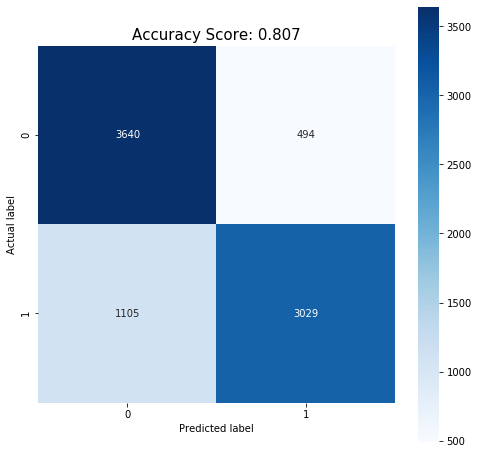

In [249]:
confusion_matrix = metrics.confusion_matrix(y_test_svm, predictions)

accuracy = metrics.accuracy_score(y_test_svm, predictions)

print('Accuracy: {0:.3f}'.format(accuracy))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test_svm, predictions)))
print('Recall score: {0:.3f}'.format(metrics.recall_score(y_test_svm, predictions)))

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", square=True, cmap="Blues");
plt.ylabel("Actual label");
plt.xlabel("Predicted label");
all_sample_title = f"Accuracy Score: {accuracy}"
plt.title(all_sample_title, size = 15);

#### Conclusion
